<a href="https://colab.research.google.com/github/K-Viera/Python/blob/main/DesicionAnalysis/Taller2Resum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports 

In [5]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split as ts
from sklearn.compose import ColumnTransformer
import seaborn as sns
import statsmodels.formula.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing
import numpy as np

#punto_1

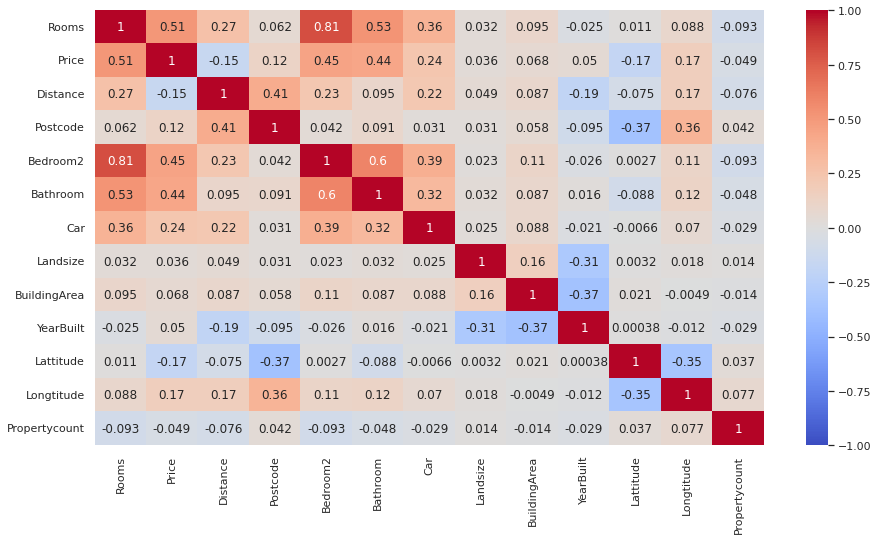

In [4]:
#datos 
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/Melbourne_housing_extra_data.csv')
df1.head()
#df1.info()
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df1.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
# como se evidencia en la gráfica de calor la variable con mayor correlacion al precio son las haitaciones 


In [6]:
#regresion lineal simple, precio-habitaciones
formula = 'Price  ~ Rooms'
model1 = sm.ols(formula = formula, data = df1.drop(df1[df1.Price.isnull()].index, inplace = False))
fitted_model1 = model1.fit()
print(fitted_model1.summary())
# regresion multivariada
formula2 =  'Price ~ Rooms+Distance+Bedroom2+Bathroom+Car+Landsize+BuildingArea+YearBuilt+Propertycount+Postcode '
model2 = sm.ols(formula = formula2, data = df1)
fitted_model2 = model1.fit()
print(fitted_model2.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     5395.
Date:                Sat, 03 Sep 2022   Prob (F-statistic):               0.00
Time:                        23:43:29   Log-Likelihood:            -2.2549e+05
No. Observations:               15396   AIC:                         4.510e+05
Df Residuals:                   15394   BIC:                         4.510e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     6.4e+04   1.42e+04      4.503      0.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15388 entries, 1 to 19739
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Suburb      15388 non-null  object 
 1   Address     15388 non-null  object 
 2   Rooms       15388 non-null  int64  
 3   Type        15388 non-null  object 
 4   Price       15388 non-null  float64
 5   Method      15388 non-null  object 
 6   SellerG     15388 non-null  object 
 7   Date        15388 non-null  object 
 8   Distance    15388 non-null  float64
 9   Postcode    15388 non-null  float64
 10  Bedroom2    15388 non-null  float64
 11  Bathroom    15388 non-null  float64
 12  Car         15388 non-null  float64
 13  Longtitude  15388 non-null  float64
 14  Regionname  15388 non-null  object 
dtypes: float64(7), int64(1), object(7)
memory usage: 1.9+ MB
None


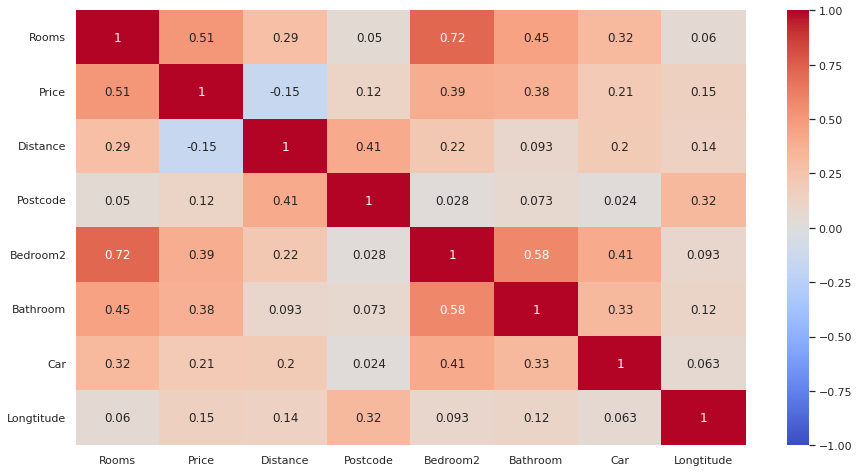

In [7]:
#redes neuronales con MLP

df1.isna().sum().sort_values()
#print(df1.info())
#limpieza de datos 
df2 = df1.drop(df1[df1.Price.isnull()].index, inplace = False)
df2.drop(df2[df2.Postcode.isnull()].index, inplace = True)
df2.drop(df2[df2.Distance.isnull()].index, inplace = True)
df2.drop(df2[df2.Regionname.isnull()].index, inplace = True)
df2.drop(['BuildingArea','YearBuilt','Landsize','Lattitude','Propertycount','CouncilArea'], axis = 1, inplace = True)
df2.fillna({'Bedroom2': df2['Bedroom2'].median()},inplace = True)
df2.fillna({'Bathroom': df2['Bathroom'].mean()},inplace = True)
df2.fillna({'Longtitude': df2['Longtitude'].mean()},inplace = True)
df2.fillna({'Car': df2['Car'].mean()},inplace = True)
print(df2.info())
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df2.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
#print(df2.CouncilArea.value_counts())
## entrenamiento y prueba sets
X_train, X_test, y_train, y_test = ts(
                                        df2.drop('Price', axis = 'columns'),
                                        df2['Price'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )


In [8]:
numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

In [9]:
print(X_train.isna().sum())
print(y_train.isna().sum())

Suburb        0
Address       0
Rooms         0
Type          0
Method        0
SellerG       0
Date          0
Distance      0
Postcode      0
Bedroom2      0
Bathroom      0
Car           0
Longtitude    0
Regionname    0
dtype: int64
0


In [10]:
#Búsqueda de hiperparámetros
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 5,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('numeric',
                                                                               Pipeline(steps=[('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Rooms',
                                                                                'Distance',
                                                                                'Postcode',
                                                                                'Bedroom2',
                                                                                'Bathroom',
                                                     

In [11]:
#Resultados
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

,param_modelo__learning_rate_init,param_modelo__hidden_layer_sizes,param_modelo__alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
1,0.01,20,10.0,-1.124073e+11,8.291373e+09,-2.065014e+07,8.814984e+06
4,0.01,10,46.415888,-1.127286e+11,6.970684e+09,-9.525867e+07,4.747990e+07
3,0.01,10,2.154435,-1.130621e+11,1.075215e+10,-4.257215e+07,2.939458e+07
2,0.01,20,0.021544,-1.138428e+11,8.548676e+09,-3.722015e+07,1.874042e+07
0,0.001,10,0.464159,-1.149197e+11,6.951008e+09,-9.435523e+07,9.458490e+07


In [13]:
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error de test (rmse): ', rmse)

Error de test (rmse):  324831.42603205424


# Punto3

In [ ]:
#datos 
df3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/analisis de decisiones/advertising.csv')
print(df3.head())
#df1.info()
print(df3.isna().sum())
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df3.corr(), vmin = -1, vmax = +1, annot = True, cmap = 'coolwarm')
# como se evidencia en la gráfica de calor la variable con mayor correlacion al precio son las haitaciones 


In [ ]:
#regresion lineal simple, precio-habitaciones
formula4 = 'Sales  ~ TV'
model4 = sm.ols(formula = formula4, data = df3)
fitted_model4 = model4.fit()
print(fitted_model4.summary())
## mejor modelo de regresion tv 

#regresion lineal simple, precio-habitaciones
formula5 = 'Sales  ~ Radio'
model5 = sm.ols(formula = formula5, data = df3)
fitted_model5 = model5.fit()
print(fitted_model5.summary())

#regresion lineal simple, precio-habitaciones
formula6 = 'Sales  ~ Newspaper'
model6 = sm.ols(formula = formula6, data = df3)
fitted_model6 = model6.fit()
print(fitted_model6.summary())

In [ ]:
X_train, X_test, y_train, y_test = ts(
                                        df3.drop('Sales', axis = 'columns'),
                                        df3['Sales'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])



In [ ]:
#verificar datos 
print(X_train.info(), X_train.isna().sum())



In [ ]:
#Búsqueda de hiperparámetros
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'r2',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

In [ ]:
#Resultados
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)